Vamos a poder seleccionar para el entrenamiento sobre todas las características que queramos.  

In [2]:
import sys 
BASE_DIR="/home/arturosf/Documentos/repos/second_CTA_analysis"
sys.path.append(f"{BASE_DIR}/src/CTA-data-analisis-library/")
import numpy as np 
import matplotlib.pyplot as plt
import os 
import re 
import glob 
import tensorflow as tf 
import seaborn as sns
import pandas as pd

#propias
import unzipdata_and_first_treatments as manipulate
import loaddata4use
import model_creation_functions as models

In [3]:
PATH_TXT=f"{BASE_DIR}/data_full/combined/SimTelArray_2022_05"


In [4]:
list_aux=glob.glob(f"{PATH_TXT}/extract_electron/*.txt")
list_aux=sorted(list_aux)
print(len(list_aux))

1460


In [5]:
#La idea es tener un diccionario enorme de todo lo que podemos necesitar para seleccionar el rango de todo y las distribuciones.  
# Esto lo logramos con los datos de extract  
aux=loaddata4use.extract_info_txt(list_aux[1455])
list_aux[1455]

'/home/arturosf/Documentos/repos/second_CTA_analysis/data_full/combined/SimTelArray_2022_05/extract_electron/electron_tel_4_run_366.txt'

(591, 26)


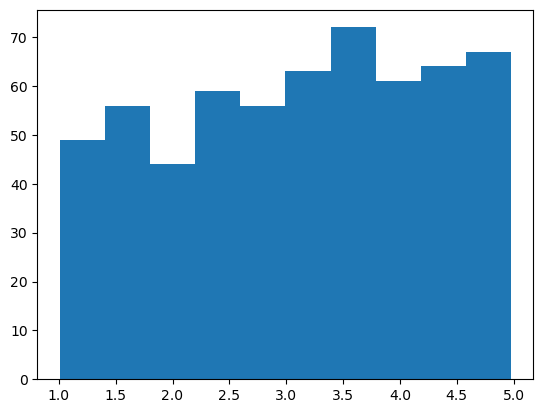

In [6]:
plt.hist(aux[:,2])
print(aux.shape)

In [7]:
cols_names=["event"
,"telescope"
,"energy"
,"core distance to telescope"
,"image size (amplitude) [p.e.]"
,"number of pixels in image"
,"width [deg.]"
,"length [deg.]"
,"distance [deg.]"
,"miss [deg.]"
,"alpha [deg.]"
,"orientation [deg.]"
,"direction [deg.]"
,"image c.o.g. x [deg.]"
,"image c.o.g. y [deg.]"
,"Xmax [g/cm^2]"
,"Hmax [m]"
,"Npe (true number of photo-electrons)"
,"(19-23): Hottest pixel amplitudes)"]
len(cols_names)

19

Tengo todas las runs y todos los eventos con sus respectivas runs. Voy a hacer lo siguiente.  
- Tomaré todos los eventos disponibles para una distribución uniforme de energias ,y haré tanto la clasificacion como la regresión de energías. Con los mismo RUNS para el train y luego test unos diferentes que para train, pero los mismos entre clasificación y regresion.  


In [8]:
archivo_min_pares = [1, 1, 1, 1, 1, 1, 1]
archivo_min_indices_pares = [91, 361, 421, 309, 387, 347, 417]
archivo_max_pares = [90, 360, 420, 308, 386, 346, 416]
archivo_max_indices_pares = [100, 370, 430, 320, 400, 360, 434]


Tenemos la info de cada run y todos los elementos, y lo que nos gustaria es elegir unas cuantas runs y saber para cada elemento, que distribucion de energias tenemos.  

In [9]:
list_aux[0]

'/home/arturosf/Documentos/repos/second_CTA_analysis/data_full/combined/SimTelArray_2022_05/extract_electron/electron_tel_1_run_001.txt'

In [10]:
int(re.findall("(\d{3})\.txt",list_aux[0])[0])

1

In [11]:
# voy a cargar toda la info de los txt para cada elemento 
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
aux2=[]
for i , elemento in enumerate(elementos):
    #dict_master[elemento]={}
    list_aux=glob.glob(f"{PATH_TXT}/extract_{elemento}/*.txt")
    list_aux=sorted(list_aux)

    for dir_aux in list_aux:
        run_aux=int(re.findall("(\d{3})\.txt",dir_aux)[0])
        tel_aux=int(re.findall("tel_(\d{1})_run",dir_aux)[0])
        #La idea es tener un diccionario enorme de todo lo que podemos necesitar para seleccionar el rango de todo y las distribuciones.  
        # Esto lo logramos con los datos de extract  
        array_aux=loaddata4use.extract_info_txt(dir_aux)
        if array_aux.size>0:
            aux2.append({"elemento":elemento,"run":run_aux,"tel":tel_aux,"energia":array_aux[:,2],"eventos":array_aux[:,0].astype(int)})
        else:
            aux2.append({"elemento":elemento,"run":run_aux,"tel":tel_aux,"energia":np.nan,"eventos":np.nan})
df_final=pd.DataFrame.from_dict(aux2)
    
df_final

,elemento,run,tel,energia,eventos
0,gamma,1,1,"[0.1087, 0.0616, 0.0904, 4.5563, 0.3297, 0.057...","[800, 1200, 1700, 2300, 3600, 4200, 4300, 5200..."
1,gamma,2,1,"[0.0957, 0.0321, 0.2691, 0.0559, 0.2708, 1.74,...","[100, 400, 700, 2100, 2500, 3100, 3300, 3500, ..."
2,gamma,3,1,NaN,NaN
3,gamma,4,1,"[0.0424, 0.1245, 0.0328, 0.0341, 1.0774, 0.070...","[100, 200, 700, 1800, 2200, 2600, 3500, 3900, ..."
4,gamma,5,1,"[0.2236, 0.2041, 0.0704, 0.1473, 0.0458, 0.095...","[200, 600, 800, 1000, 1700, 1900, 3500, 3600, ..."
...,...,...,...,...,...
9628,silicon,356,4,"[4.4503, 4.3298, 3.8065, 4.5505, 4.7329, 3.959...","[4100, 6900, 7800, 10100, 10200, 11600, 13800,..."
9629,silicon,357,4,"[3.2706, 4.7084, 4.9035, 3.0785, 3.5371, 4.756...","[400, 1200, 2100, 7400, 9300, 10700, 11700, 13..."
9630,silicon,358,4,"[4.8596, 4.8966, 2.2676, 4.0688, 4.3492, 2.959...","[700, 2700, 8300, 9000, 15400, 16300, 20500, 2..."
9631,silicon,359,4,"[2.1081, 2.8272, 3.8519, 2.8368, 4.525, 3.0555...","[1700, 3900, 5300, 6700, 11300, 12400, 14300, ..."


In [12]:
df_final.groupby(["elemento","run"]).apply(lambda x : pd.Series([False]*x.shape[0]) if x["eventos"].isna().any() else pd.Series([True]*x.shape[0]))==False

elemento  run   
electron  1    0    False
               1    False
               2    False
               3    False
          2    0    False
                    ...  
silicon   359  3    False
          360  0    False
               1    False
               2    False
               3    False
Length: 9633, dtype: bool

In [13]:
df_clean=df_final.groupby(["elemento","run"]).apply(lambda x: x if len(list(x["tel"]))==4 else print(list(x["tel"]))).dropna().reset_index(drop=True)

[1, 2, 3]
[1, 3, 4]
[1, 2, 3]
[1, 3, 4]
[1, 3, 4]
[1, 2, 3]
[1, 3, 4]
[1, 3, 4]
[1, 3, 4]
[1, 3, 4]
[1, 2, 3]
[1, 2, 4]
[2, 3, 4]
[1, 3, 4]
[1, 2, 3]
[1, 3, 4]
[1, 2, 4]
[1, 2, 4]
[1, 2, 4]
[1, 2, 3]
[1, 2, 3]
[1, 2, 4]
[1, 2, 4]


In [14]:
df_clean

,elemento,run,tel,energia,eventos
0,electron,1,1,"[0.7343, 0.2967, 0.1307, 0.2604, 0.1603, 0.052...","[21200, 35900, 55300, 61000, 74000, 74800, 752..."
1,electron,1,2,"[0.1307, 0.1603, 0.0522, 0.0365, 0.0358, 0.803...","[55300, 74000, 74800, 77500, 77700, 82500, 894..."
2,electron,1,3,"[0.2227, 0.1307, 0.1603, 0.1108, 0.0358, 0.803...","[800, 55300, 74000, 75200, 77700, 82500, 10600..."
3,electron,1,4,"[0.2227, 0.7343, 0.2967, 0.1307, 0.2604, 0.161...","[800, 21200, 35900, 55300, 61000, 62300, 74000..."
4,electron,2,1,"[0.0566, 0.0508, 0.0656, 1.5473, 0.7692, 0.529...","[13900, 35800, 47100, 50700, 54300, 63600, 638..."
...,...,...,...,...,...
9535,silicon,359,4,"[2.1081, 2.8272, 3.8519, 2.8368, 4.525, 3.0555...","[1700, 3900, 5300, 6700, 11300, 12400, 14300, ..."
9536,silicon,360,1,"[4.6059, 3.8817, 4.4777, 2.9524, 2.7399, 4.324...","[1700, 4500, 4900, 5900, 6500, 7100, 7200, 760..."
9537,silicon,360,2,"[4.6059, 3.8379, 3.8817, 4.4777, 2.9524, 2.739...","[1700, 3800, 4500, 4900, 5900, 6500, 7100, 720..."
9538,silicon,360,3,"[4.6059, 3.8379, 3.8817, 4.4777, 2.9524, 4.626...","[1700, 3800, 4500, 4900, 5900, 7600, 9100, 132..."


In [15]:
def f_get_comon_events(df):
    all_eventos=np.concatenate(df["eventos"].to_numpy())
    event,count=np.unique(all_eventos,return_counts=True)
    all_energias=np.concatenate(df["energia"].to_numpy())
    energias_eventos_comunes=[]
    for i in event[count==4]:
        indx=np.argwhere(i==all_eventos)
        if np.unique(all_energias[indx]).size!=1:
            print("Algo ha pasado con el evento i, no coinciden las energias")
        energias_eventos_comunes.append(all_energias[indx[0]][0])
    return pd.DataFrame({"eventos":event[count==4],"energia":energias_eventos_comunes})

In [16]:
df_common_events=df_clean.groupby(["elemento","run"]).apply(f_get_comon_events).droplevel(2).reset_index()#.to_frame()
#df_common_events.columns=["eventos"]
df_common_events

,elemento,run,eventos,energia
0,electron,1,55300,0.1307
1,electron,1,74000,0.1603
2,electron,1,82500,0.8038
3,electron,1,109700,0.6685
4,electron,1,152100,0.2394
...,...,...,...,...
601768,silicon,360,1796100,4.8594
601769,silicon,360,1798300,2.8470
601770,silicon,360,1798500,4.9862
601771,silicon,360,1798800,4.4138


In [17]:
df_common_events.groupby("elemento").size()

elemento
electron     86277
gamma       116135
helium       81928
iron         71055
nitrogen     87882
proton       72290
silicon      86206
dtype: int64

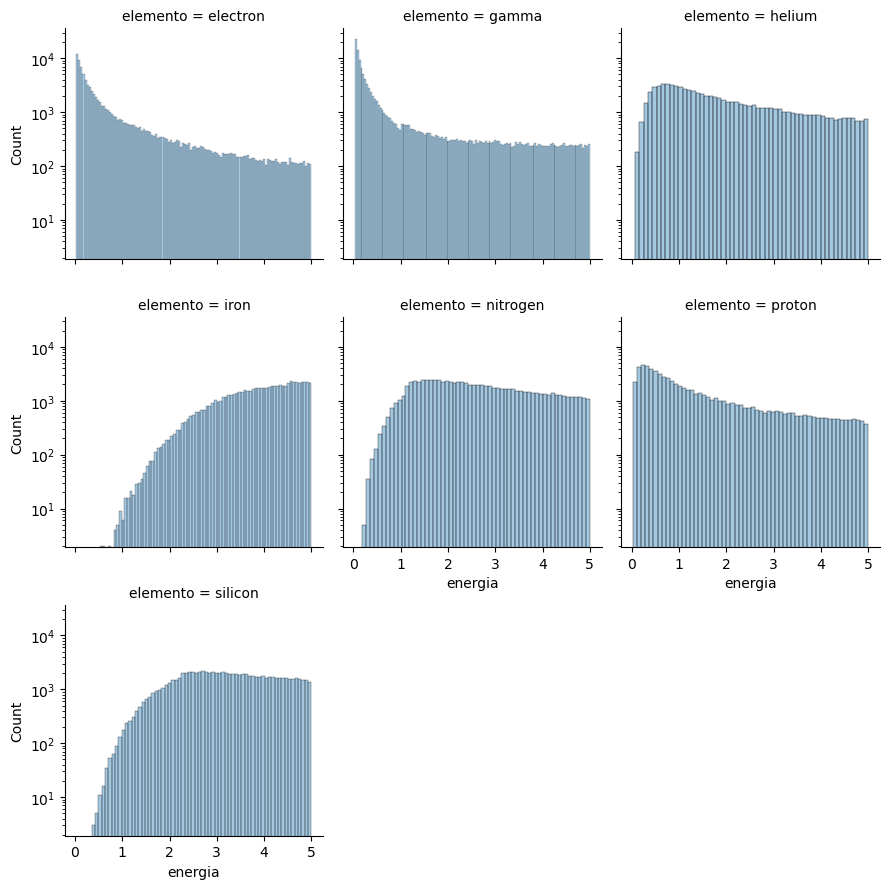

In [18]:
g = sns.FacetGrid(df_common_events, col="elemento",col_wrap=3 )
g.map(sns.histplot,"energia", alpha=.4,log_scale=[False,True])

In [19]:
df_common_events

,elemento,run,eventos,energia
0,electron,1,55300,0.1307
1,electron,1,74000,0.1603
2,electron,1,82500,0.8038
3,electron,1,109700,0.6685
4,electron,1,152100,0.2394
...,...,...,...,...
601768,silicon,360,1796100,4.8594
601769,silicon,360,1798300,2.8470
601770,silicon,360,1798500,4.9862
601771,silicon,360,1798800,4.4138


In [20]:
elementos=['gamma', 'electron', 'proton', 'helium', 'nitrogen', 'silicon', 'iron']

elemento
electron    82019
gamma       96498
helium      75907
iron        66471
nitrogen    81907
proton      67707
silicon     80742
dtype: int64


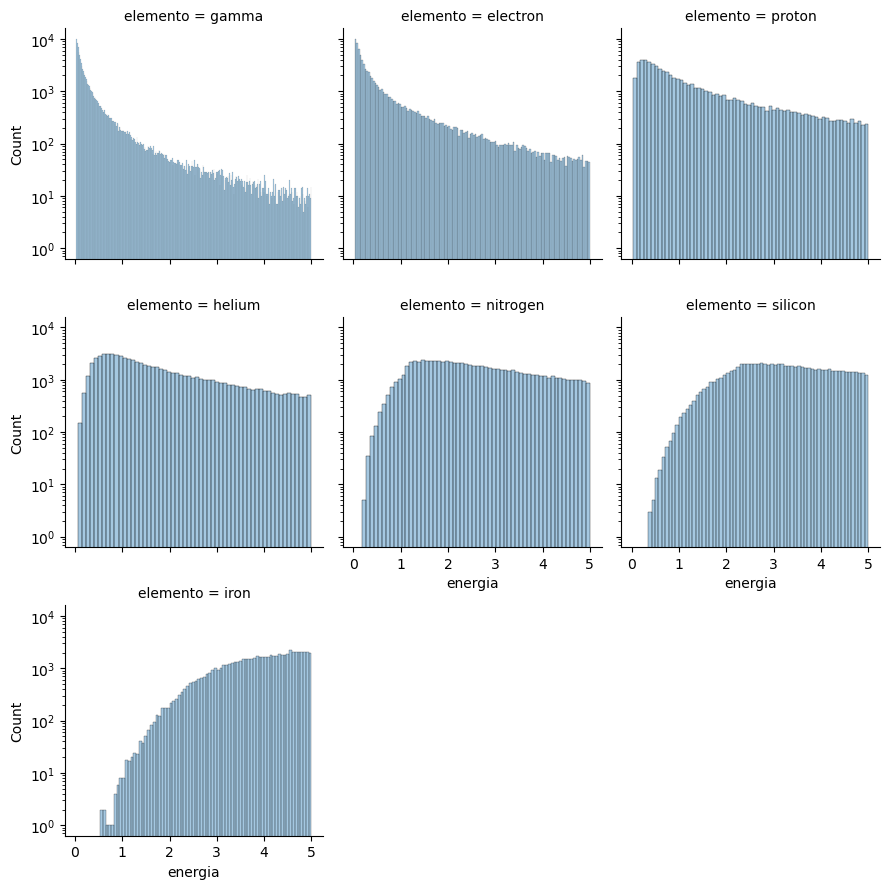

In [21]:
# vamos a hacerlo para los eventos antes y despues del cambio ese de la simulacion  

#estos siguen este orden -> ['gamma', 'electron', 'proton', 'helium', 'nitrogen', 'silicon', 'iron']
archivo_min_pares = [1, 1, 1, 1, 1, 1, 1]
archivo_min_indices_pares = [91, 361, 421, 309, 387, 347, 417]
archivo_max_pares = [90, 360, 420, 308, 386, 346, 416]
archivo_max_indices_pares = [100, 370, 430, 320, 400, 360, 434]

aux_df=[]
for j,i in enumerate(elementos):
    element_aux_df=df_common_events.loc[df_common_events["elemento"]==i]
    aux_df.append(element_aux_df.loc[(element_aux_df["run"]>=archivo_min_pares[j])&(element_aux_df["run"]<=archivo_max_pares[j])])
df_common_events_aux1=pd.concat(aux_df)
print(df_common_events_aux1.groupby("elemento").size())

g = sns.FacetGrid(df_common_events_aux1, col="elemento",col_wrap=3 )
g.map(sns.histplot,"energia", alpha=.4,log_scale=[False,True])

elemento
electron     4258
gamma       19637
helium       6021
iron         4584
nitrogen     5975
proton       4583
silicon      5464
dtype: int64


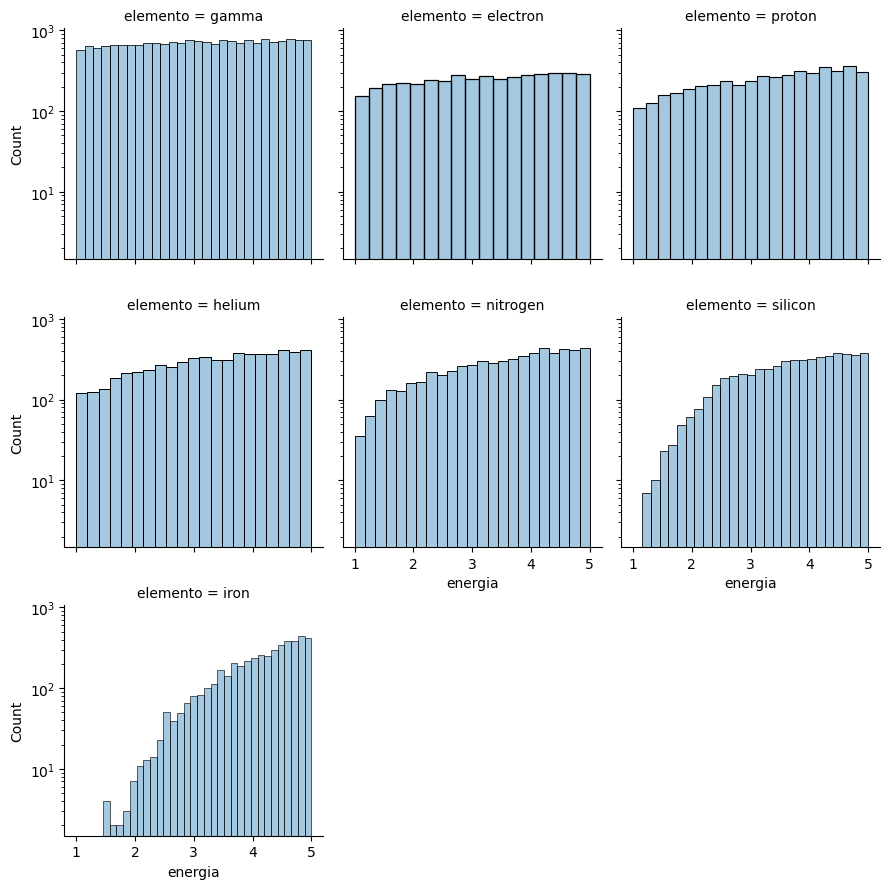

In [22]:
aux_df=[]
for j,i in enumerate(elementos):
    element_aux_df=df_common_events.loc[df_common_events["elemento"]==i]
    aux_df.append(element_aux_df.loc[(element_aux_df["run"]>=archivo_min_indices_pares[j])&(element_aux_df["run"]<=archivo_max_indices_pares[j])])
df_common_events_aux1=pd.concat(aux_df)
print(df_common_events_aux1.groupby("elemento").size())
g = sns.FacetGrid(df_common_events_aux1, col="elemento",col_wrap=3 )
g.map(sns.histplot,"energia", alpha=.4,log_scale=[False,True])

elemento
electron     86277
gamma       116135
helium       81928
iron         71055
nitrogen     87882
proton       72290
silicon      86206
dtype: int64


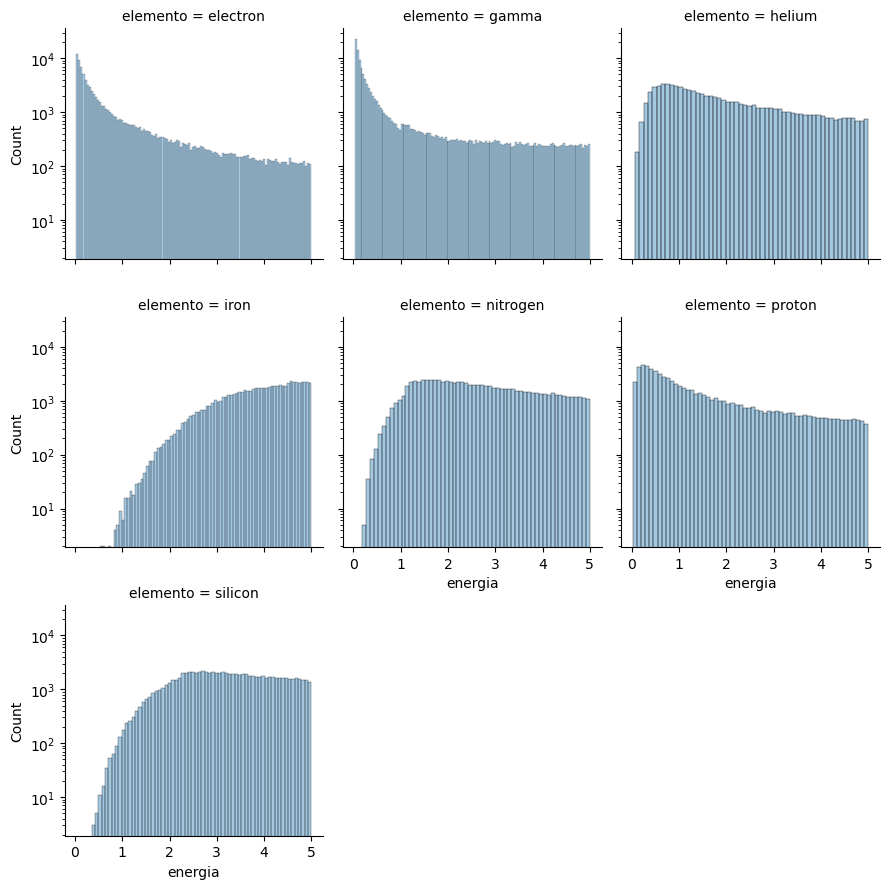

In [23]:
g = sns.FacetGrid(df_common_events, col="elemento",col_wrap=3 )
g.map(sns.histplot,"energia", alpha=.4,log_scale=[False,True])
print(df_common_events.groupby("elemento").size())


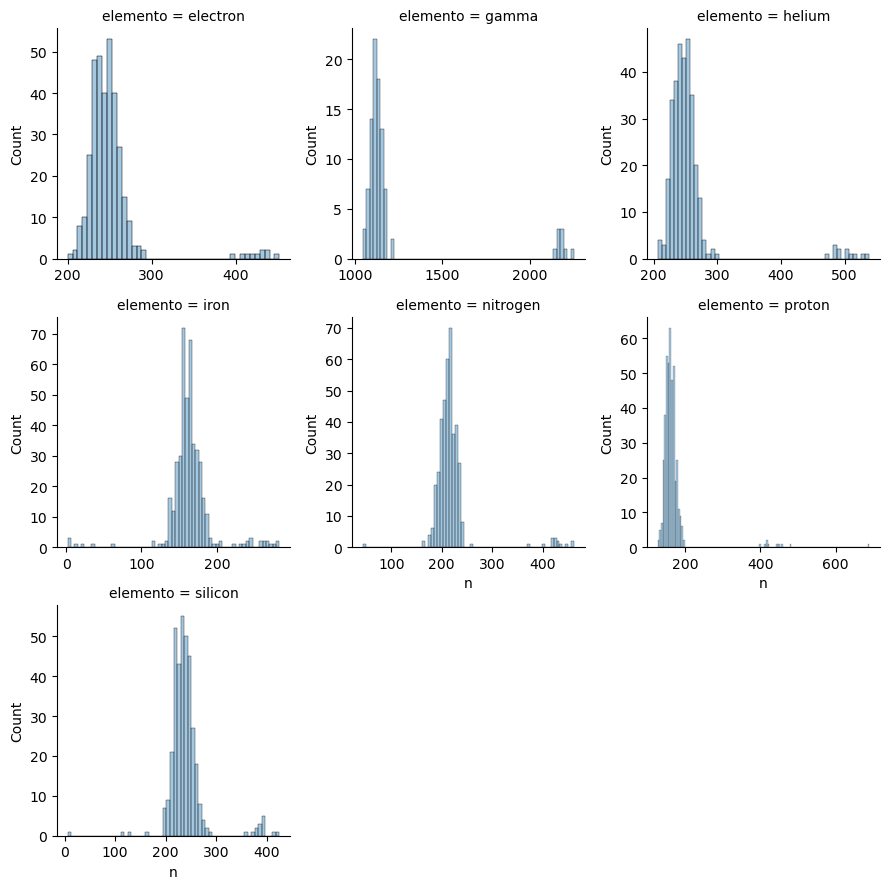

In [24]:
eventos_number=df_common_events.groupby(["elemento","run"]).size().to_frame().reset_index()
eventos_number=eventos_number.rename(columns={0:"n"})
g = sns.FacetGrid(eventos_number, col="elemento",col_wrap=3,sharex=False,sharey=False )
g.map(sns.histplot,"n", alpha=.4)

In [25]:
#vamos a seleccionar unas runs para el train y otras para el test   
eventos_number_rand=eventos_number.groupby("elemento").apply(lambda x : x.sample(frac=1)).reset_index(drop=True)
eventos_number_rand

,elemento,run,n
0,electron,70,269
1,electron,150,268
2,electron,47,222
3,electron,189,209
4,electron,19,260
...,...,...,...
2379,silicon,271,243
2380,silicon,267,248
2381,silicon,89,251
2382,silicon,204,209


In [26]:
eventos_number_rand["percent"]=eventos_number_rand.groupby("elemento")["n"].transform(lambda x : x/x.sum())
eventos_number_rand

,elemento,run,n,percent
0,electron,70,269,0.003118
1,electron,150,268,0.003106
2,electron,47,222,0.002573
3,electron,189,209,0.002422
4,electron,19,260,0.003014
...,...,...,...,...
2379,silicon,271,243,0.002819
2380,silicon,267,248,0.002877
2381,silicon,89,251,0.002912
2382,silicon,204,209,0.002424


In [27]:
eventos_number_rand["cumsum"]=eventos_number_rand.groupby("elemento")["percent"].transform(lambda x : x.cumsum())
eventos_number_rand

,elemento,run,n,percent,cumsum
0,electron,70,269,0.003118,0.003118
1,electron,150,268,0.003106,0.006224
2,electron,47,222,0.002573,0.008797
3,electron,189,209,0.002422,0.011220
4,electron,19,260,0.003014,0.014233
...,...,...,...,...,...
2379,silicon,271,243,0.002819,0.988829
2380,silicon,267,248,0.002877,0.991706
2381,silicon,89,251,0.002912,0.994618
2382,silicon,204,209,0.002424,0.997042


In [28]:
#ahora para cada elemento, vamos a guardar los runs que contienen el 80% de los datos
eventos_number_rand.loc[eventos_number_rand["cumsum"]<0.80,"mode"]="Train"
eventos_number_rand["mode"]=eventos_number_rand["mode"].fillna("Test")
eventos_number_rand


,elemento,run,n,percent,cumsum,mode
0,electron,70,269,0.003118,0.003118,Train
1,electron,150,268,0.003106,0.006224,Train
2,electron,47,222,0.002573,0.008797,Train
3,electron,189,209,0.002422,0.011220,Train
4,electron,19,260,0.003014,0.014233,Train
...,...,...,...,...,...,...
2379,silicon,271,243,0.002819,0.988829,Test
2380,silicon,267,248,0.002877,0.991706,Test
2381,silicon,89,251,0.002912,0.994618,Test
2382,silicon,204,209,0.002424,0.997042,Test


In [29]:
eventos_number_rand.groupby(["elemento","mode"]).size()/eventos_number_rand.groupby(["elemento"]).size()


elemento  mode 
electron  Test     0.200000
          Train    0.800000
gamma     Test     0.210526
          Train    0.789474
helium    Test     0.196875
          Train    0.803125
iron      Test     0.200461
          Train    0.799539
nitrogen  Test     0.195000
          Train    0.805000
proton    Test     0.202326
          Train    0.797674
silicon   Test     0.197222
          Train    0.802778
dtype: float64

In [30]:
df_lista_runs=eventos_number_rand.groupby(["elemento","mode"]).apply(lambda x : list(x["run"])).to_frame(name="list_runs").reset_index()
df_lista_runs

,elemento,mode,list_runs
0,electron,Test,"[179, 365, 244, 350, 112, 167, 360, 109, 68, 2..."
1,electron,Train,"[70, 150, 47, 189, 19, 88, 343, 9, 95, 24, 140..."
2,gamma,Test,"[69, 86, 6, 61, 13, 25, 57, 62, 19, 60, 31, 95..."
3,gamma,Train,"[99, 50, 56, 75, 76, 34, 49, 53, 51, 23, 24, 4..."
4,helium,Test,"[268, 64, 10, 175, 225, 114, 178, 227, 54, 201..."
5,helium,Train,"[142, 197, 85, 133, 254, 203, 13, 88, 24, 29, ..."
6,iron,Test,"[4, 223, 221, 147, 259, 12, 373, 72, 327, 395,..."
7,iron,Train,"[228, 68, 240, 222, 23, 210, 219, 428, 204, 22..."
8,nitrogen,Test,"[13, 53, 200, 239, 147, 372, 118, 227, 382, 15..."
9,nitrogen,Train,"[237, 250, 111, 4, 254, 231, 299, 33, 194, 381..."


In [31]:
elementos=['gamma', 'electron', 'proton', 'helium', 'nitrogen', 'silicon', 'iron']
train_runs=df_lista_runs.loc[df_lista_runs["mode"]=="Train"].set_index("elemento")
train_runs=train_runs.loc[elementos].reset_index()
train_runs_list=list(train_runs["list_runs"].to_numpy())
print(len(train_runs_list),[len(i) for i in train_runs_list])
train_runs

7 [75, 276, 343, 257, 322, 289, 347]


,elemento,mode,list_runs
0,gamma,Train,"[99, 50, 56, 75, 76, 34, 49, 53, 51, 23, 24, 4..."
1,electron,Train,"[70, 150, 47, 189, 19, 88, 343, 9, 95, 24, 140..."
2,proton,Train,"[416, 63, 51, 62, 428, 179, 193, 261, 245, 233..."
3,helium,Train,"[142, 197, 85, 133, 254, 203, 13, 88, 24, 29, ..."
4,nitrogen,Train,"[237, 250, 111, 4, 254, 231, 299, 33, 194, 381..."
5,silicon,Train,"[176, 231, 223, 315, 195, 117, 31, 188, 8, 109..."
6,iron,Train,"[228, 68, 240, 222, 23, 210, 219, 428, 204, 22..."


In [32]:
test_runs=df_lista_runs.loc[df_lista_runs["mode"]=="Test"].set_index("elemento")
test_runs=test_runs.loc[elementos].reset_index()
test_runs_list=list(test_runs["list_runs"].to_numpy())
print(len(test_runs_list),[len(i) for i in test_runs_list])
test_runs

7 [20, 69, 87, 63, 78, 71, 87]


,elemento,mode,list_runs
0,gamma,Test,"[69, 86, 6, 61, 13, 25, 57, 62, 19, 60, 31, 95..."
1,electron,Test,"[179, 365, 244, 350, 112, 167, 360, 109, 68, 2..."
2,proton,Test,"[59, 30, 223, 336, 10, 83, 220, 84, 309, 186, ..."
3,helium,Test,"[268, 64, 10, 175, 225, 114, 178, 227, 54, 201..."
4,nitrogen,Test,"[13, 53, 200, 239, 147, 372, 118, 227, 382, 15..."
5,silicon,Test,"[360, 330, 159, 234, 292, 212, 91, 183, 2, 138..."
6,iron,Test,"[4, 223, 221, 147, 259, 12, 373, 72, 327, 395,..."


## La parte del entrenamiento con esas runs 

In [33]:
PATH_npy=f"{BASE_DIR}/data_full/combined/elementos_npy"
PATH_npy

'/home/arturosf/Documentos/repos/second_CTA_analysis/data_full/combined/elementos_npy'

In [34]:
os.listdir(PATH_npy)

['npy_iron',
 'npy_silicon',
 'npy_gamma',
 'npy_proton',
 'npy_nitrogen',
 'npy_electron',
 'npy_helium']

In [35]:
train_runs

,elemento,mode,list_runs
0,gamma,Train,"[99, 50, 56, 75, 76, 34, 49, 53, 51, 23, 24, 4..."
1,electron,Train,"[70, 150, 47, 189, 19, 88, 343, 9, 95, 24, 140..."
2,proton,Train,"[416, 63, 51, 62, 428, 179, 193, 261, 245, 233..."
3,helium,Train,"[142, 197, 85, 133, 254, 203, 13, 88, 24, 29, ..."
4,nitrogen,Train,"[237, 250, 111, 4, 254, 231, 299, 33, 194, 381..."
5,silicon,Train,"[176, 231, 223, 315, 195, 117, 31, 188, 8, 109..."
6,iron,Train,"[228, 68, 240, 222, 23, 210, 219, 428, 204, 22..."


In [36]:
aux_list=[i[:2] for i in train_runs_list]

In [37]:
x_train_list,x_test_list,y_train_list,y_test_list=loaddata4use.load_dataset_completo(PATH_npy,labels_asign=[0,1,2,2,2,2,2],elements=elementos,
                                                                                    main_list_runs=aux_list,pre_name_folders="npy_",telescopes=[1,2,3,4],
                                                                                    test_size=0.1,same_quant="all",verbose=True,fill=True,categorical=True)



Load of names and common events
_______________
0 ;  Element:  gamma  , Runs:  [99, 50]  Shape of common events (tels,common events):  (4, 2257)
1 ;  Element:  gamma  , Runs:  [99, 50]  Shape of common events (tels,common events):  (4, 1118)
0 ;  Element:  electron  , Runs:  [70, 150]  Shape of common events (tels,common events):  (4, 269)
1 ;  Element:  electron  , Runs:  [70, 150]  Shape of common events (tels,common events):  (4, 268)
0 ;  Element:  proton  , Runs:  [416, 63]  Shape of common events (tels,common events):  (4, 145)
1 ;  Element:  proton  , Runs:  [416, 63]  Shape of common events (tels,common events):  (4, 146)
0 ;  Element:  helium  , Runs:  [142, 197]  Shape of common events (tels,common events):  (4, 231)
1 ;  Element:  helium  , Runs:  [142, 197]  Shape of common events (tels,common events):  (4, 226)
0 ;  Element:  nitrogen  , Runs:  [237, 250]  Shape of common events (tels,common events):  (4, 223)
1 ;  Element:  nitrogen  , Runs:  [237, 250]  Shape of common e

Element:  gamma , Telescope:  1  Shape of loaded array (amount of images, size of images):  (3375, 93, 55)
Element:  electron , Telescope:  1  Shape of loaded array (amount of images, size of images):  (537, 93, 55)
Element:  proton , Telescope:  1  Shape of loaded array (amount of images, size of images):  (291, 93, 55)
Element:  helium , Telescope:  1  Shape of loaded array (amount of images, size of images):  (457, 93, 55)
Element:  nitrogen , Telescope:  1  Shape of loaded array (amount of images, size of images):  (421, 93, 55)
Element:  silicon , Telescope:  1  Shape of loaded array (amount of images, size of images):  (508, 93, 55)
Element:  iron , Telescope:  1  Shape of loaded array (amount of images, size of images):  (305, 93, 55)
Element:  gamma , Telescope:  2  Shape of loaded array (amount of images, size of images):  (3375, 93, 55)
Element:  electron , Telescope:  2  Shape of loaded array (amount of images, size of images):  (537, 93, 55)
Element:  proton , Telescope:  2

In [38]:
def cambiar_ejes_lista(lista):
    for i,j in enumerate(lista):
        lista[i]=np.swapaxes(j,1,2)
    return lista

In [39]:
x_train_list=cambiar_ejes_lista(x_train_list)
x_test_list=cambiar_ejes_lista(x_test_list)

In [40]:
modelo=models.model_multi_tel(classes=3,filtros=[[32,64],[64,64],[32,16]],last_dense=[20,5])
modelo.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["acc","AUC","mean_squared_error"])

2023-06-17 02:07:29.533472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 02:07:29.534263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 02:07:29.547068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 02:07:29.547722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 02:07:29.548135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [41]:
from numba import cuda

In [43]:
device = cuda.get_current_device()

hist=modelo.fit(x=x_train_list,y=y_train_list,epochs=2, validation_data=(x_test_list,y_test_list),batch_size=64)            


Epoch 1/2
83/83 [==============================] - 14s 166ms/step - loss: 0.5377 - acc: 0.8982 - auc: 0.9673 - mean_squared_error: 0.0792 - val_loss: 0.5272 - val_acc: 0.8864 - val_auc: 0.9653 - val_mean_squared_error: 0.0793
Epoch 2/2
83/83 [==============================] - 14s 166ms/step - loss: 0.4987 - acc: 0.8965 - auc: 0.9675 - mean_squared_error: 0.0752 - val_loss: 0.4713 - val_acc: 0.9000 - val_auc: 0.9742 - val_mean_squared_error: 0.0707


In [ ]:
file_number="012"
n=19 #repes de boostrap
#primer bucle para arquitecturas
for i,arch in enumerate(opciones_filtros):
    print(f"{i}: {arch} \n")
    modelo=models.model_multi_tel(classes=3,filtros=arch,last_dense=[20,5])
    modelo.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["acc","AUC","mean_squared_error"])
    with open(f"{base_dir}/automat/logs/{file_number}_data_control.txt","a") as registro:
        registro.write(f"Con arquitectura: {arch} : \n")

    #segundo_bucle para boostrap
    for k in range(n):
        print(f"\n Boostrap {k+1} de {n}")

        #list_runs=new_create_main_list_runs([8,35,24,24,24,24,24],chose_runs)
        list_runs=new_create_main_list_runs([1,1,1,1,1,1,1],chose_runs)
        with open(f"{base_dir}/automat/logs/{file_number}_data_control.txt","a") as registro:
            registro.write(f"Boostrap {k+1} de {n},runs: {list_runs}, \n")
        x_train_list,x_test_list,y_train_list,y_test_list=loaddata4use.load_dataset_completo(npy_final_dir,labels_asign=[0,1,2,2,2,2,2],elements=elements,
                                                                                            main_list_runs=list_runs,pre_name_folders="npy_",telescopes=[1,2,3,4],
                                                                                            test_size=0.3,same_quant="same",verbose=True,fill=True,categorical=True)
        x_train_list=cambiar_ejes_lista(x_train_list)
        x_test_list=cambiar_ejes_lista(x_test_list)

        
        hist=modelo.fit(x=x_train_list,y=y_train_list,epochs=45, validation_data=(x_test_list,y_test_list),batch_size=64)            
        gc.collect()
        del x_train_list,x_test_list,y_train_list,y_test_list
        modelo.save(f"{base_dir}/modelos/{file_number}_modelo_filtro_{i}_en_boostrap_stage_{k+1}.h5")
        with open(f"{base_dir}/modelos/performances/{file_number}_history_modelo_filtro_{i}_en_boostrap_stage_{k+1}.pickle","wb") as pick:
            pickle.dump(hist,pick)
    gc.collect()
    del modelo 
    tf.keras.backend.clear_session()
    device.reset()
